In [1]:
import os
import sys
sys.path.append("lib")
import torch
import torch.nn as nn
import torch.optim as optim

import utils
import classifier
from genre_data import genre_data


# Pre-training

## Default values for training and testing

In [2]:
#* Data path
DATA_PATH = "data/genres.json"

#* Network type
NN_TYPE = 'FNN'

#* Set default precision to double(float 64)
PRECISION = '32'
torch.set_default_dtype(getattr(torch, 'float' + PRECISION))

#* Portion of validation size
VAL_SIZE = 0.3

#* Set model path
def model_path(epoch):
    model_name = NN_TYPE + "_{}.pth".format(epoch)
    return os.path.join('model', model_name)

#* Check device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE


device(type='cuda', index=0)

## Generate dataset

In [3]:
data = genre_data(DATA_PATH, val_size=VAL_SIZE, precision=PRECISION, verbose=True)
train_loader = data.get_train_loader(batch_size=32)
val_loader = data.get_val_loader()


Finished reading a file data/genres.json
-----------------------------
Number of train set: 3498 with input: torch.Size([259, 13]) output: torch.Size([])
Number of validation set: 1500 with input: torch.Size([259, 13]) output: torch.Size([])


## Define neural network, loss function, optimizer type

In [22]:
model = getattr(classifier, NN_TYPE)(input_size=data.input_size, output_size=data.output_size).to(DEVICE)
utils.model_summary(model, input_size=data.input.shape[1:], precision=PRECISION)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=0.01)


Layer (type:depth-idx)                   Input Shape      Output Shape     Kernel Shape     Param #          Mult-Adds
├─Linear: 1-1                            [1, 3367]        [1, 512]         [3367, 512]      1,724,416        1,723,904
├─ReLU: 1-2                              [1, 512]         [1, 512]         --               --               --
├─Dropout: 1-3                           [1, 512]         [1, 512]         --               --               --
├─Linear: 1-4                            [1, 512]         [1, 256]         [512, 256]       131,328          131,072
├─ReLU: 1-5                              [1, 256]         [1, 256]         --               --               --
├─Dropout: 1-6                           [1, 256]         [1, 256]         --               --               --
├─Linear: 1-7                            [1, 256]         [1, 64]          [256, 64]        16,448           16,384
├─ReLU: 1-8                              [1, 64]          [1, 64]          --    

## Load model if needed

In [5]:
#* Load model
epoch = 50

checkpoint = torch.load(model_path(epoch), map_location=DEVICE)
epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_func = checkpoint['loss']


# Training

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train finished with 79.264561seconds


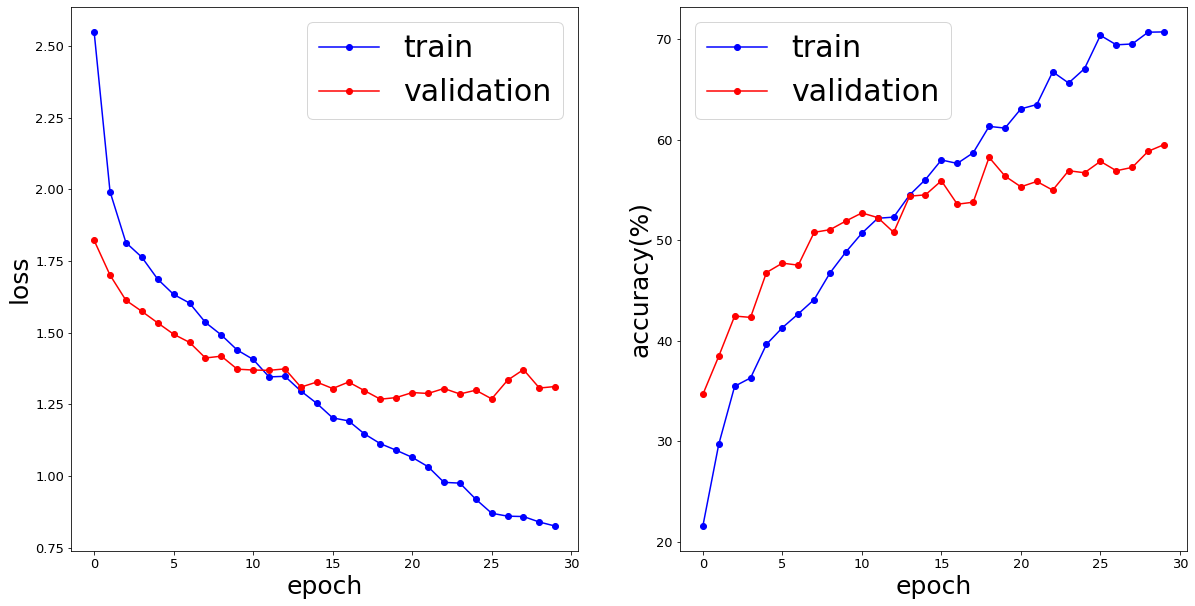

In [23]:
epoch = 30

history = utils.train(model,
                      max_epoch=epoch,
                      loss_func=loss_func,
                      optimizer=optimizer,
                      train_loader=train_loader,
                      val_loader=val_loader,
                      device=DEVICE,
                      verbose=False)
utils.plot_loss_accuracy(*history)


# Test

Test accuracy: 59.53%
Test finished with 3.16 seconds


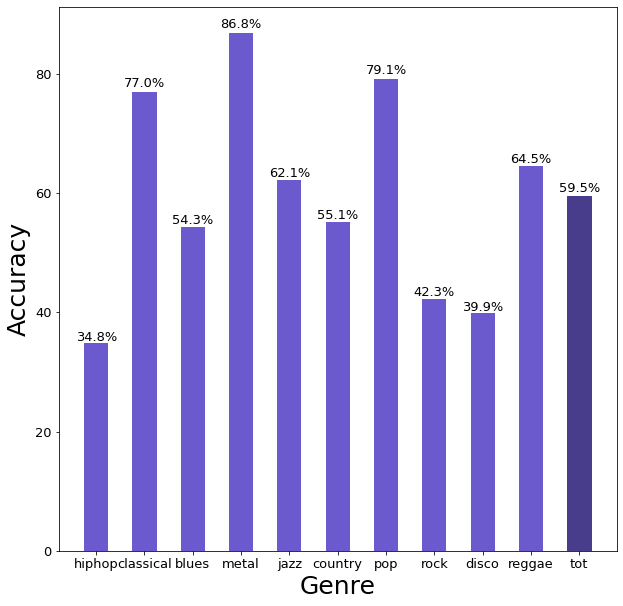

In [24]:
accuracy = utils.test(model, data, device=DEVICE, verbose=True)
utils.plot_accuracy(accuracy)


# Save the model

In [25]:
torch.save({'epoch': epoch,
            'model_state_dict': model.to('cpu').state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func},
           model_path(epoch))

model.to(DEVICE)


FNN(
  (fc1): Linear(in_features=3367, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)